# Classification of Anomalous Diffusion

We'll develop a recurrent neural network to classify different kinds of motions obeying different anomalous diffusion models.

## Load Anomalous Diffusion Models

We load the `datasets_theory()` class from the `andi_datasets` package.

In [1]:
from andi_datasets.datasets_theory import datasets_theory

AnDi = datasets_theory()
model_names = AnDi.avail_models_name
model_number = len(model_names)

print(f"{model_number} nomalous diffusion models: {model_names}")


5 nomalous diffusion models: ['attm', 'ctrw', 'fbm', 'lw', 'sbm']


## Simulate Trajectories

We now proceed to simulate the necessary trajectories for the dataset. This might take a few minutes. This will generate `N = 4000` trajectories for each anomalous diffusion model, each with random anomalous diffusion coefficients. Each trajectory contains `T = 100` time steps.

The dataset contains rows with lenght `2 + D * T`, with the following structure:
* First column: model label 
* Second column: value of the anomalous exponent
* Following columns: trajectories

In [2]:
from numpy import concatenate as cat
from numpy.random import rand

T = 100  # Time steps.
N = 4000  # Trajectories per model.
D = 2  # Dimensionality.

dataset = cat((
    AnDi.create_dataset(  # CARLO: should we use a create_noisy_diffusion_dataset?
        T=T, 
        N_models=1, 
        exponents=(rand(N) + 0.2) / 1.2,
        models=[0, 1],  # attm, ctrw
        dimension=D, 
    ),
    AnDi.create_dataset(  # CARLO: should we use a create_noisy_diffusion_dataset?
        T=T, 
        N_models=1, 
        exponents=(rand(N) * 1.8) + 0.2,
        models=[2, 4],  # fbm, sbm
        dimension=D, 
    ),
    AnDi.create_dataset(  # CARLO: should we use a create_noisy_diffusion_dataset?
        T=T, 
        N_models=1, 
        exponents=rand(N) + 1,
        models=3,  # lw
        dimension=D, 
    ),
), axis=0)

print(f"{dataset.shape}")

(20000, 202)


## adding localization noise

We now shuffle the dataset and extract the model numbers, anomalous exponents, and the x and y components of the trajectories.

In [3]:
from numpy.random import shuffle

shuffle(dataset)

models = dataset[:, 0]
exponents = dataset[:, 1]
trajectories = dataset[:, 2:].reshape(-1, T, D, order='F')


We also standardize the trajectories.

In [4]:
trajectories -= trajectories.mean(axis=1, keepdims=True)
trajectories /= trajectories.std(axis=1, keepdims=True) + 1e-6  # CARLO: there are some trajectories whsoe std are nan, can you check why?

## Visualize Trajectories

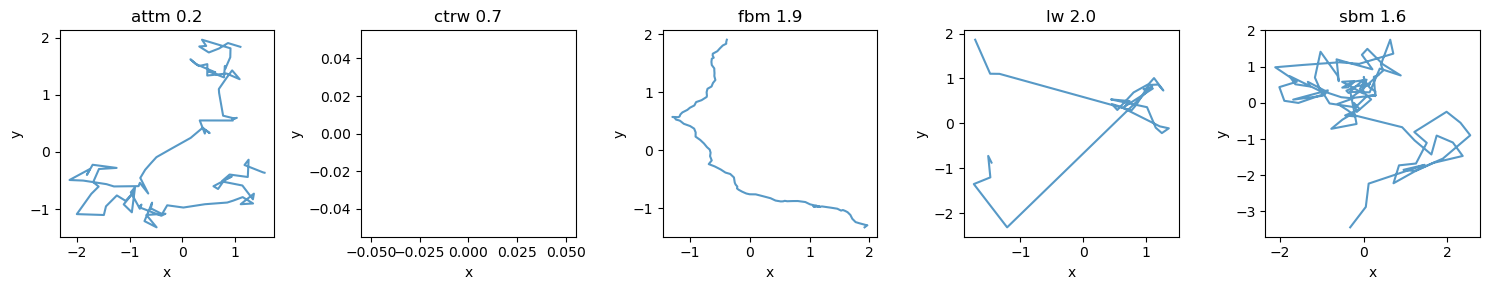

In [5]:
import matplotlib.pyplot as plt
from numpy import where

fig, axs = plt.subplots(1, model_number, figsize=((15, 3)), tight_layout=True)

for m, ax in zip(range(model_number), axs):
    idx = where(models == m)[0][0]
    ax.plot(trajectories[idx, :, 0], trajectories[idx, :, 1], alpha = 0.75)
    ax.set_title(f"{model_names[m]} {exponents[idx]:.1f}")
    plt.setp(ax, xlabel="x", ylabel="y")

## Prepare Data

We now prepare the data to be used by for the neural network training. We start by reshaping the trajectories according to a tme `window` to be used in the recurrent neural network training.

In [6]:
window = 2
n_timesteps = int(T / window)
n_features= D * window

inputs = trajectories.reshape(trajectories.shape[0], n_timesteps, n_features)

We then one-hot encode the targets. For this, we first implement two functions, that we add to `fnc_andi.py` ...

```python
```

```python
```

... and then use them to one-hot encode the anomalous diffusion models.

In [7]:
from numpy import argmax, zeros

def digits_to_one_hot(digits, n_classes):
    """Convert an array of integer digits to a 2D one-hot encoded matrix."""
    
    one_hot_labels = zeros((digits.shape[0], n_classes))
    for idx, digit in enumerate(digits): 
        one_hot_labels[idx, digit] = 1
    return one_hot_labels
    
def one_hot_to_digit(one_hot_labels):
    """Convert a 2D one-hot encoded matrix to a 1D array of integer digits."""
    
    return argmax(one_hot_labels , axis=-1)


In [8]:
#from fnc_andi import digits_to_one_hot

targets = digits_to_one_hot(models.astype(int), model_number)

We then convert them into PyTorch tensors ...

In [9]:
import torch

inputs = torch.tensor(inputs, dtype=torch.float32)
targets = torch.tensor(targets, dtype=torch.float32)

... split them into train, validation, and test datasets ...

In [10]:
from torch.utils.data import random_split, TensorDataset

[train_ds, val_ds, test_ds] = random_split(TensorDataset(inputs, targets), 
                                           [0.6, 0.2, 0.2])

... and create the necessary data loaders.

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

## Use Simple RNN

We start by using a simple RNN.

In [23]:
import deeplay as dl

rnn = dl.RNN(
    n_features, 
    hidden_features=[100],
    out_features=model_number,
    dropout=0.2,
    rnn_type="RNN", 
)
rnn.blocks.dropout.configure(p=0.2)  # HENRIK, BENJAMIN: I need to add this to see the dropout in the printout

model_rnn = dl.Classifier(
    rnn, 
    loss=torch.nn.CrossEntropyLoss(), 
    optimizer=dl.Adam(lr=0.001)
).create()

print(model_rnn)  # HENRIK, BENJAMIN: There seems to be a problem in the implementaiton of dropout (see printout)

Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): RNN(4, 100, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=100, out_features=5, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNorm

We now proceed to train the neural network ...

In [24]:
trainer_rnn = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_rnn.fit(model_rnn, train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 11.1 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
11.1 K    Trainable params
0         Non-trainable params
11.1 K    Total params
0.044     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


... and test it on the test dataset ...

In [25]:
preds_rnn = trainer_rnn.predict(model_rnn, test_loader)
preds_rnn = torch.cat(preds_rnn, dim=0).clone().detach()

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

... and evaluate its performance. For this, we write the `get_groundtruths()` and `accuracy()` functions, save them into `fnc_andi.py` ...

```python
```

```python
```

... and use it to calculate the accuracy.

In [26]:
import torch


def get_groundtruths(loader):
    """Returns the groundtruth targets."""
    
    groundtruths = []
    for _, target in loader:
        groundtruths.append(target)
        
    groundtruths = torch.cat(groundtruths, dim=0)
    groundtruths = torch.tensor(groundtruths)
    
    return groundtruths
    

def accuracy(predictions, groundtruths):
    """Calculate the accuracy."""
    
    predictions = one_hot_to_digit(predictions) 
    groundtruths = one_hot_to_digit(groundtruths)
    correct = sum(predictions == groundtruths)
    total = predictions.shape[0]
    return correct / total

In [27]:
#from fnc_andi import accuracy, get_groundtruths

groundtruths = get_groundtruths(test_loader)

accuracy_rnn = accuracy(preds_rnn, groundtruths)
print(f"Accuracy Simple RNN: {accuracy_rnn}")

Accuracy Simple RNN: 0.3644999861717224


/var/folders/hq/wmcbgp7s56b98c9mjf167rz40000gn/T/ipykernel_49298/4124532768.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  groundtruths = torch.tensor(groundtruths)


We then plot the confusion matrix.

```python
```

In [34]:
import matplotlib.pyplot as plt
from numpy import zeros
from seaborn import heatmap, cubehelix_palette


def plot_confusion_matrix(predictions, groundtruths):
    """Calculate and plot confusion matrix."""

    confusion_matrix = zeros((5, 5))
    predictions = one_hot_to_digit(predictions) 
    groundtruths = one_hot_to_digit(groundtruths)
    for pred_idx, gt_idx in zip(predictions, groundtruths):
        confusion_matrix[pred_idx, gt_idx] += 1
    confusion_matrix *= 100 / confusion_matrix.sum(axis=0, keepdims=1)

    plt.figure(figsize=(10, 8))
    heatmap(confusion_matrix, annot=True, fmt=".1f", square=True, 
            cmap=cubehelix_palette(light=0.95, as_cmap=True), vmax=100)
    plt.xlabel("Predicted model", fontsize=15)
    xlocs, _ = plt.xticks()
    plt.xticks(ticks=xlocs, labels=model_names)
    plt.ylabel("Ground truth model", fontsize=15)
    ylocs, _ = plt.yticks()
    plt.yticks(ticks=ylocs, labels=model_names)
    plt.show()

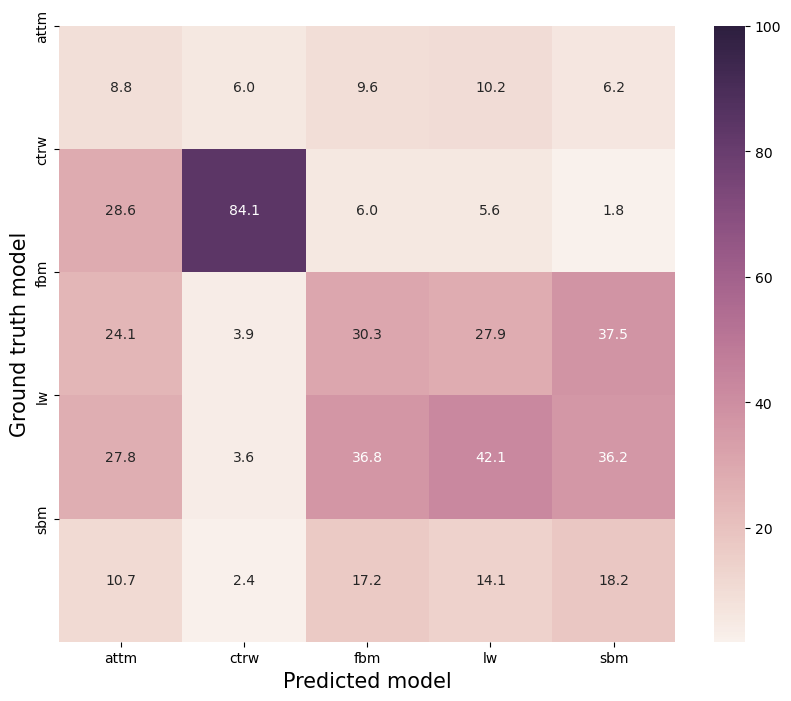

In [29]:
#from fnc_andi import plot_confusion_matrix

plot_confusion_matrix(preds_rnn, groundtruths)

## Use GRU

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 32.3 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
32.3 K    Trainable params
0         Non-trainable params
32.3 K    Total params
0.129     Total estimated model params size (MB)


Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): GRU(4, 100, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=100, out_features=5, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNorm

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Accuracy Simple RNN: 0.49050000309944153


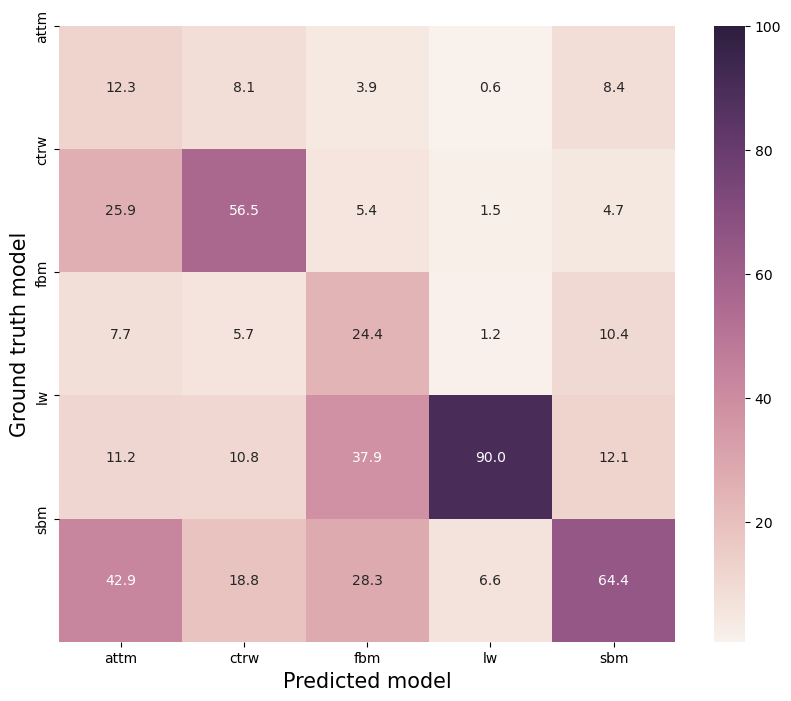

In [31]:
rnn.blocks[0].layer.configure(torch.nn.GRU)
model_gru = dl.Classifier(rnn, 
                          loss=torch.nn.CrossEntropyLoss(),
                          optimizer=dl.Adam(lr=0.01)).create()

print(model_gru)

trainer_gru = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_gru.fit(model_gru, train_loader, val_dataloaders=val_loader)

preds_gru = trainer_rnn.predict(model_gru, test_loader)
preds_gru = torch.cat(preds_gru, dim=0).clone().detach()

accuracy_gru = accuracy(preds_gru, groundtruths)
print(f"Accuracy GRU: {accuracy_gru}")

plot_confusion_matrix(preds_gru, groundtruths)

## Use LSTM

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 11.5 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)


Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(4, 50, batch_first=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=50, out_features=5, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNorma

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Accuracy LSTM: 0.6510000228881836


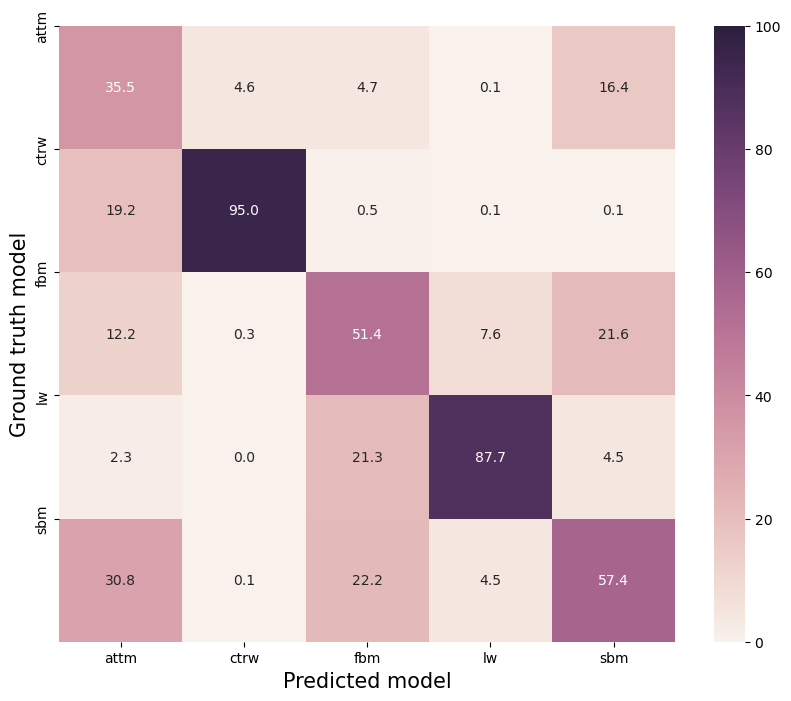

In [32]:
rnn.blocks[0].layer.configure(torch.nn.LSTM)
rnn.blocks[0].layer.configure(hidden_size=50)  # To bring the total parameter count more in-line with a simple RNN.
rnn.blocks[1].layer.configure(in_features=50)
model_lstm = dl.Classifier(rnn, 
                          loss=torch.nn.CrossEntropyLoss(),
                          optimizer=dl.Adam(lr=0.01)).create()

print(model_lstm)

trainer_lstm = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_lstm.fit(model_lstm, train_loader, val_dataloaders=val_loader)

preds_lstm = trainer_rnn.predict(model_lstm, test_loader)
preds_lstm = torch.cat(preds_lstm, dim=0).clone().detach()

accuracy_lstm = accuracy(preds_lstm, groundtruths)
print(f"Accuracy LSTM: {accuracy_lstm}")

plot_confusion_matrix(preds_lstm, groundtruths)

## Use Bidirectional LSTM

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | RNN              | 22.7 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
22.7 K    Trainable params
0         Non-trainable params
22.7 K    Total params
0.091     Total estimated model params size (MB)


Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): RNN(
    (blocks): LayerList(
      (0): RecurrentNeuralNetwork(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): LSTM(4, 50, batch_first=True, bidirectional=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Drop()
          )
        )
      )
      (1): MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LayerActivationNormalizationDropout(
            (layer): Linear(in_features=50, out_features=5, bias=True)
            (activation): Identity()
            (normalization): Identity()
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
      )
    )
    (rnn): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Accuracy Bidirectional LSTM: 0.7287499904632568


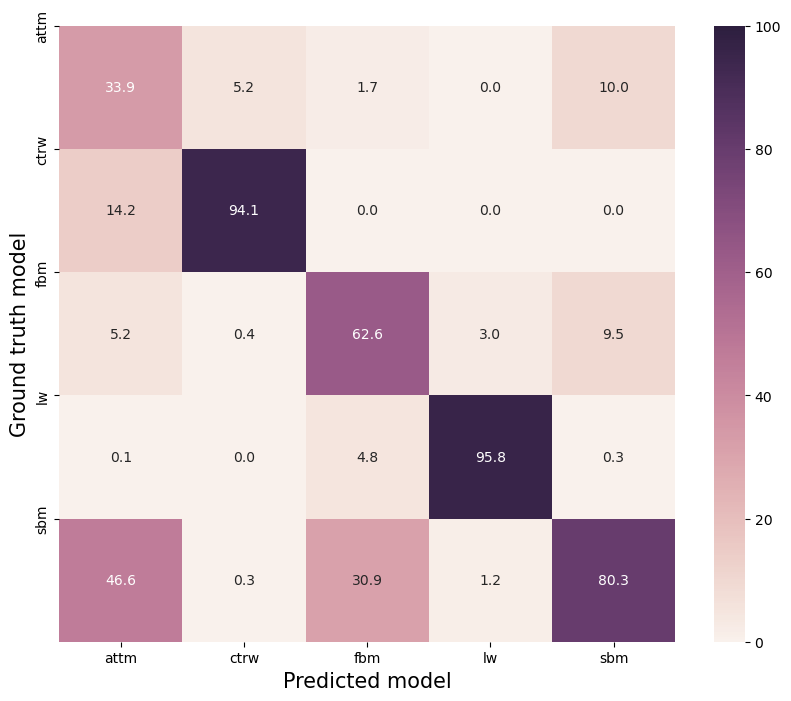

In [33]:
rnn = dl.RNN(
    n_features,
    hidden_features=[50],
    out_features=model_number,
    dropout=0.2,
    rnn_type="LSTM",
    bidirectional=True,
)
rnn.blocks.dropout.configure(p=0.2)  # HENRIK, BENJAMIN: I need to add this to see the dropout in the printout
model_bi = dl.Classifier(
    rnn, 
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=dl.Adam(lr=0.01)
).create()

print(model_bi)

trainer_bi = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_bi.fit(model_bi, train_loader, val_dataloaders=val_loader)

preds_bi = trainer_rnn.predict(model_bi, test_loader)
preds_bi = torch.cat(preds_bi, dim=0).clone().detach()

accuracy_bi = accuracy(preds_bi, groundtruths)
print(f"Accuracy Bidirectional LSTM: {accuracy_bi}")

plot_confusion_matrix(preds_bi, groundtruths)

## Adding layers to LSTM (overfitting)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | CrossEntropyLoss | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 58.3 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
58.3 K    Trainable params
0         Non-trainable params
58.3 K    Total params
0.233     Total estimated model params size (MB)


Classifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): Sequential(
    (0): RecurrentNeuralNetwork(
      (blocks): LayerList(
        (0): LayerActivationNormalizationDropout(
          (layer): LSTM(4, 100)
          (activation): Identity()
          (normalization): Identity()
          (dropout): Drop()
        )
        (1): LayerActivationNormalizationDropout(
          (layer): LSTM(100, 30)
          (activation): Identity()
          (normalization): Identity()
          (dropout): Drop()
        )
      )
    )
    (1): MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LayerActivationNormalizationDropout(
          (layer): LazyLinear(in_features=0, out_features=15, bias=True)
          (activation): ReLU()
          (normalization): Identity()
          (dropout): Dropout(p=0.2, inplace=False)
      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Accuracy Bidirectional LSTM: 0.6959999799728394


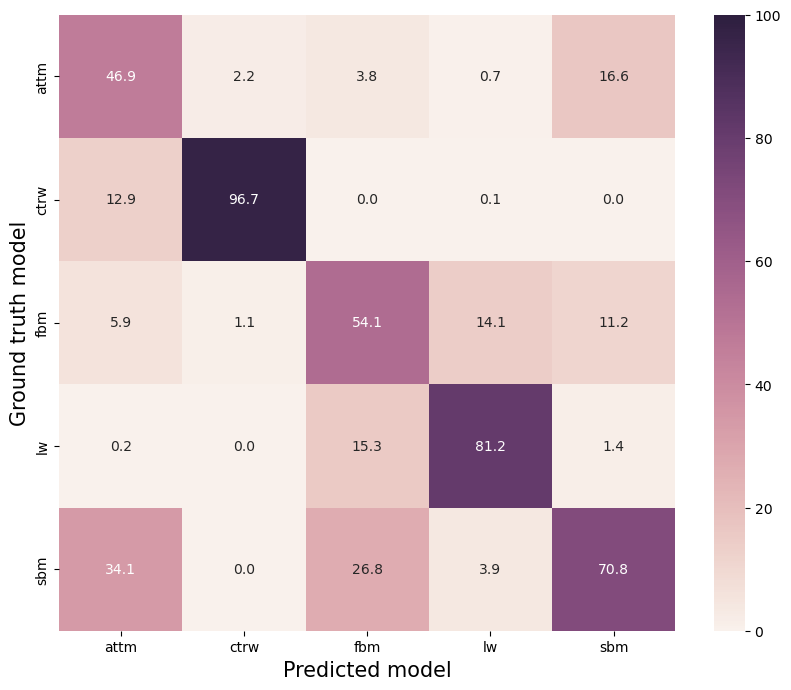

In [37]:
rnn = dl.RecurrentNeuralNetwork(  # HENRIK, BENJAMIN: why not RNN like above?
    n_features,
    hidden_features=[100],
    out_features=30,
)
rnn.blocks.dropout.configure(p=0.2)  # HENRIK, BENJAMIN: I need to add this to see the dropout in the printout
rnn.blocks.layer.configure(torch.nn.LSTM)  # HENRIK, BENJAMIN: this shouldn't be needed because it's above, right?

dense_top = dl.MultiLayerPerceptron(
    in_features=None,
    hidden_features=[15],
    out_features=model_number,
)
dense_top.blocks.dropout.configure(p=0.2)  # HENRIK, BENJAMIN: can this be put as an argument?

dense_rnn = dl.Sequential(rnn, dense_top)
model_overfit = dl.Classifier(
    dense_rnn, 
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=dl.Adam(lr=0.01),
).create()

print(model_overfit)

trainer_overfit = dl.Trainer(max_epochs=30, accelerator="auto")
trainer_overfit.fit(model_overfit, train_loader, val_dataloaders=val_loader)

preds_overfit = trainer_rnn.predict(model_overfit, test_loader)
preds_overfit = torch.cat(preds_overfit, dim=0).clone().detach()

accuracy_overfit = accuracy(preds_overfit, groundtruths)
print(f"Accuracy Bidirectional LSTM: {accuracy_overfit}")

plot_confusion_matrix(preds_overfit, groundtruths)